# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/tilted/Particle-Stack/"
star_file = "T40_HA_130K-Equalized_run-data.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  130000
load_data: data loaded, time:  64.73381161689758


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(130000, 256, 256)
(130000,)
(130000, 3)
(130000, 2)
(130000, 9)


### Only keep N points at random (to avoid out of memory error)

In [5]:
N = 10000# imgs0.shape[0]
idxrand = np.random.permutation(130000)[:N]

imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 2.560000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 3.200000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(10000, 1024)


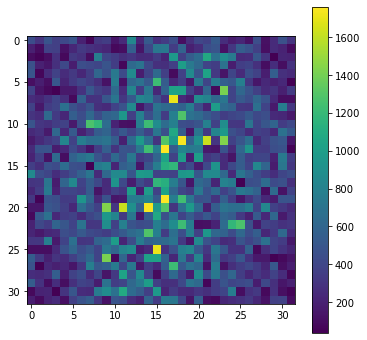

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

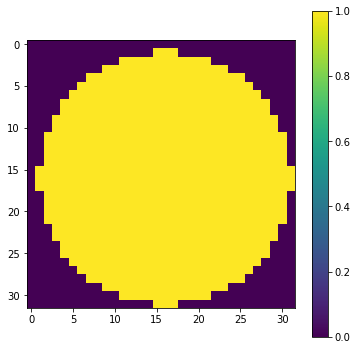

In [12]:
centre = (0,0,0)
radius = 0.045
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

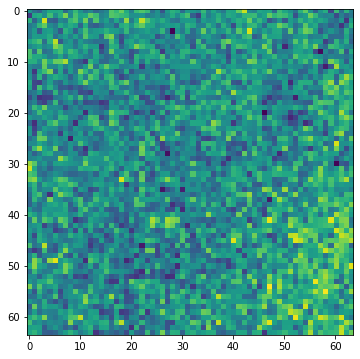

In [13]:
N_noise = 64
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Only use a small subset of the data for noise estimation so the kernel doesn't crash (possibly due to running out of memory)

Text(0.5, 1.0, 'Estimated noise')

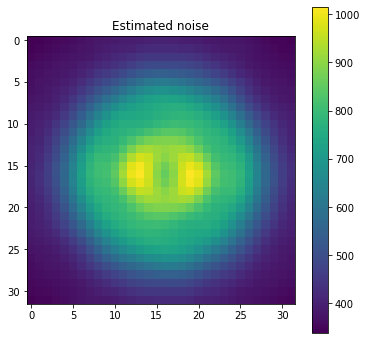

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

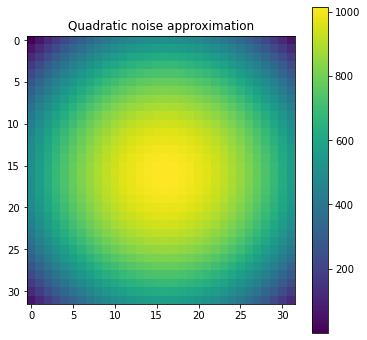

In [15]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

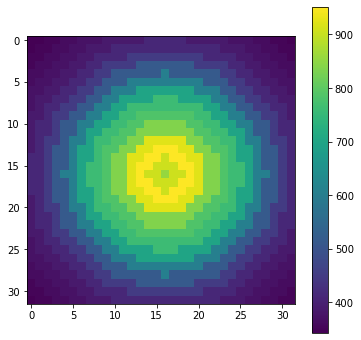

In [16]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

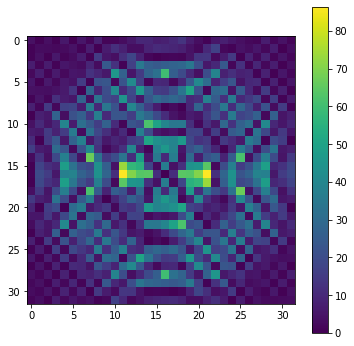

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

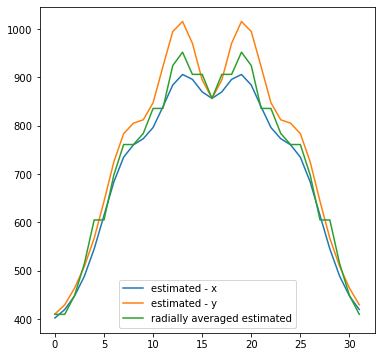

In [18]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
#plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
#plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [19]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [20]:
del(imgs0)
#del(imgs)

### Ab initio

In [21]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [22]:
#sys.stdout = sys.__stdout__

In [23]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

Fourier radius: 0.04771
Starting radius: 0.01
Frequency marching step size: 0.005164759001819446
Number of frequency marching steps: 8
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 1.192557142556128e-07
  sgd epoch 10: mean gradient = 2.54845142975814e-08
  sgd epoch 20: mean gradient = 1.6991804290316183e-08
  sgd epoch 30: mean gradient = 2.1146608094101633e-08
  sgd epoch 40: mean gradient = 1.2190778368276759e-08
  sgd epoch 50: mean gradient = 1.2615738263958906e-10


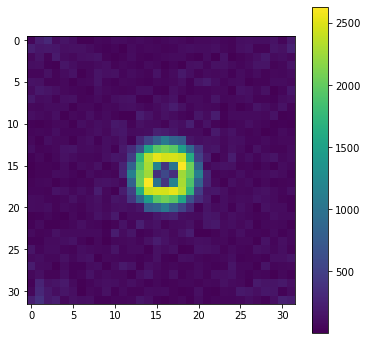

Iter  0
  MC sample 20 , loss = 17.48258761394846
  Time orientations sampling = 7.074032306671143
  Iter 20 , a =  0.9999933578960488
  MC sample 20 , loss (of mean) = 17.777111995755043
  Time vol optimisation = 9.261560440063477
2022-02-28 23:04:00.957717
  nx = 8


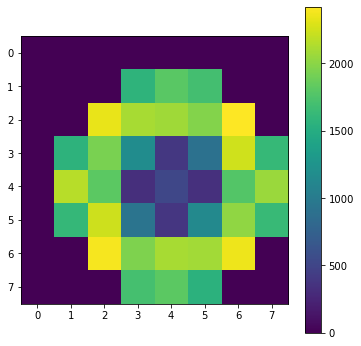

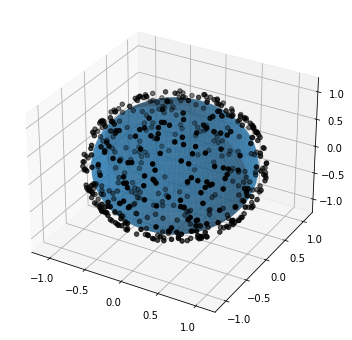

Iter  1
  MC sample 20 , loss = 43.63317669115758
  Time orientations sampling = 3.870504140853882
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.871455631562
  Time vol optimisation = 10.686352729797363
Iter  2
  MC sample 20 , loss = 42.416030745255156
  Time orientations sampling = 3.8732082843780518
  Iter 20 , a =  0.9999960648763041
  MC sample 20 , loss (of mean) = 42.795496802765875
  Time vol optimisation = 8.199373245239258
Iter  3
  MC sample 20 , loss = 42.36531685852448
  Time orientations sampling = 4.0951642990112305
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.750302991903446
  Time vol optimisation = 8.313822507858276
Iter  4
  MC sample 20 , loss = 42.280314063019226
  Time orientations sampling = 3.8686013221740723
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.66553480961754
  Time vol optimisation = 8.445949792861938
Iter  5
  MC sample 20 , loss = 42.15997028353956
  Time orientations sampling = 3.8720176219940186
  Iter 20 , a =

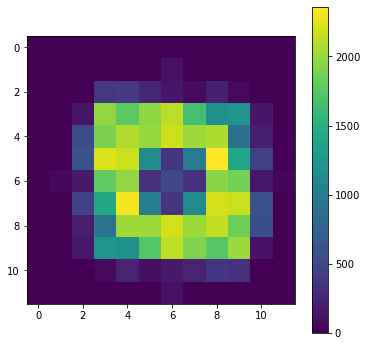

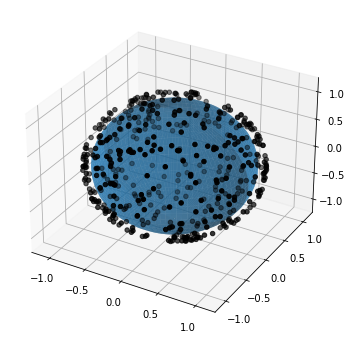

Iter  9
  MC sample 20 , loss = 70.46675486750428
  Time orientations sampling = 5.456739902496338
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 70.80164936630912
  Time vol optimisation = 12.521146774291992
Iter  10
  MC sample 20 , loss = 70.2226108897036
  Time orientations sampling = 5.0636467933654785
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 70.60544455126713
  Time vol optimisation = 10.371452331542969
Iter  11
  MC sample 20 , loss = 70.03608332962804
  Time orientations sampling = 5.243479251861572
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 70.43942826411012
  Time vol optimisation = 10.276632308959961
Iter  12
  MC sample 20 , loss = 69.87476112056905
  Time orientations sampling = 4.943955421447754
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 70.29877979285351
  Time vol optimisation = 10.36524486541748
Iter  13
  MC sample 20 , loss = 69.75456201820973
  Time orientations sampling = 4.987818479537964
  Iter 20 , a =  1.0
  MC samp

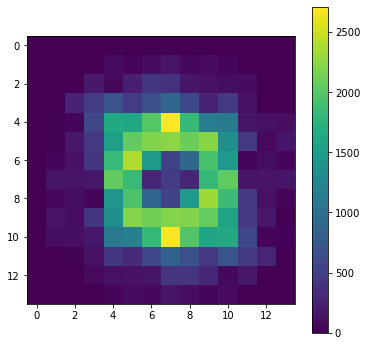

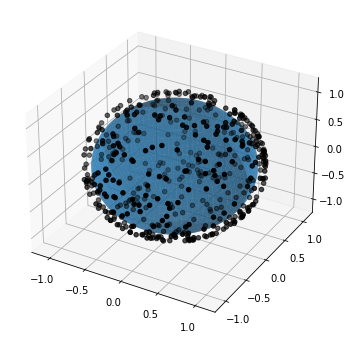

Iter  17
  MC sample 20 , loss = 119.49776543680929
  Time orientations sampling = 6.22005558013916
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 119.664707164555
  Time vol optimisation = 16.650205373764038
Iter  18
  MC sample 20 , loss = 118.9072694634487
  Time orientations sampling = 6.246648073196411
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 119.28023317470013
  Time vol optimisation = 14.969972133636475
Iter  19
  MC sample 20 , loss = 118.58967162881122
  Time orientations sampling = 6.1888816356658936
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 119.00584206039564
  Time vol optimisation = 14.49465298652649
Iter  20
  MC sample 20 , loss = 118.30417981527305
  Time orientations sampling = 6.265110731124878
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 118.72448705532686
  Time vol optimisation = 15.01190185546875
Iter  21
  MC sample 20 , loss = 118.00789452184588
  Time orientations sampling = 6.224081993103027
  Iter 20 , a =  1.0
  M

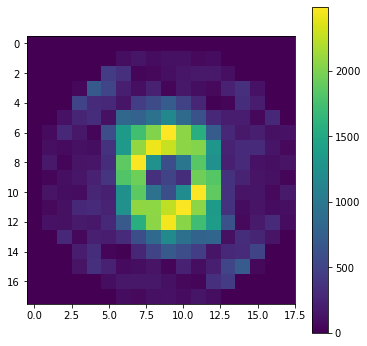

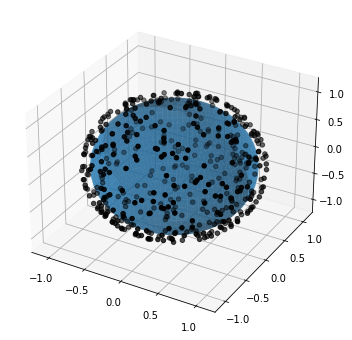

Iter  25
  MC sample 20 , loss = 173.05193960240769
  Time orientations sampling = 7.14548134803772
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 173.1009045883581
  Time vol optimisation = 21.604377031326294
Iter  26
  MC sample 20 , loss = 172.2064003794547
  Time orientations sampling = 7.510859489440918
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 172.57140588033772
  Time vol optimisation = 19.55377984046936
Iter  27
  MC sample 20 , loss = 171.77650922533047
  Time orientations sampling = 7.047292470932007
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 172.17672115627698
  Time vol optimisation = 19.428028345108032
Iter  28
  MC sample 20 , loss = 171.3909051201421
  Time orientations sampling = 6.962439060211182
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 171.85400768947437
  Time vol optimisation = 19.419694423675537
Iter  29
  MC sample 20 , loss = 171.09561693003792
  Time orientations sampling = 7.635711193084717
  Iter 20 , a =  1.0
  M

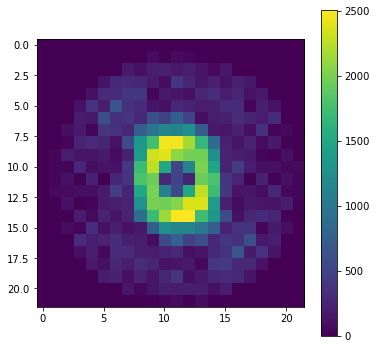

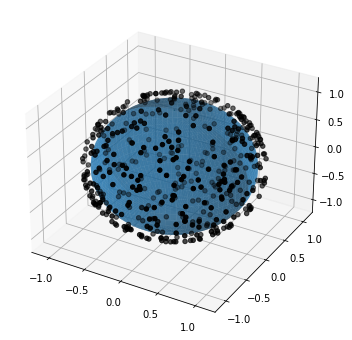

Iter  33
  MC sample 20 , loss = 224.09811088227215
  Time orientations sampling = 8.14101505279541
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 224.44403720223914
  Time vol optimisation = 27.821425914764404
Iter  34
  MC sample 20 , loss = 223.7416198984448
  Time orientations sampling = 8.045999765396118
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 224.22893971925515
  Time vol optimisation = 26.15702533721924
Iter  35
  MC sample 20 , loss = 223.5448672685787
  Time orientations sampling = 8.017088651657104
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 224.05649872730123
  Time vol optimisation = 25.575267791748047
Iter  36
  MC sample 20 , loss = 223.38016039484563
  Time orientations sampling = 7.974770784378052
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 223.9092189053883
  Time vol optimisation = 25.6429922580719
Iter  37
  MC sample 20 , loss = 223.24227155900877
  Time orientations sampling = 8.05082893371582
  Iter 20 , a =  1.0
  MC s

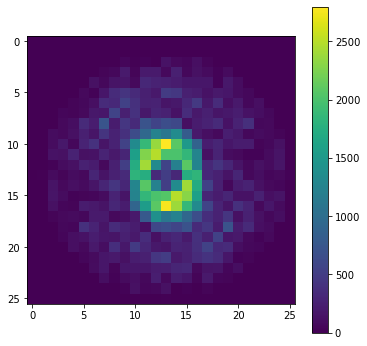

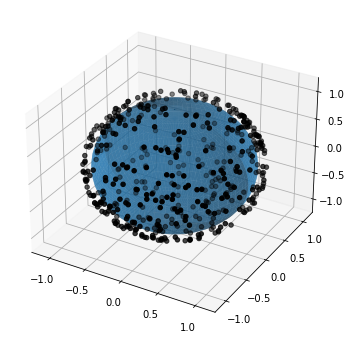

Iter  41
  MC sample 20 , loss = 295.75714657269543
  Time orientations sampling = 8.609421968460083
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 296.02655601085394
  Time vol optimisation = 32.493531465530396
Iter  42
  MC sample 20 , loss = 295.3187099554883
  Time orientations sampling = 8.542118549346924
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 295.8135232317827
  Time vol optimisation = 30.077780723571777
Iter  43
  MC sample 20 , loss = 295.1123425644895
  Time orientations sampling = 8.600152015686035
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 295.6398839684153
  Time vol optimisation = 30.707226514816284
Iter  44
  MC sample 20 , loss = 294.9697320388165
  Time orientations sampling = 8.59058666229248
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 295.52133763002536
  Time vol optimisation = 30.044697046279907
Iter  45
  MC sample 20 , loss = 294.8480937767377
  Time orientations sampling = 8.657767295837402
  Iter 20 , a =  1.0
  MC 

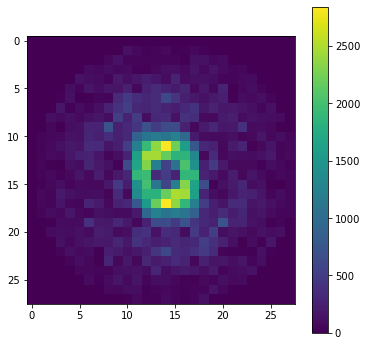

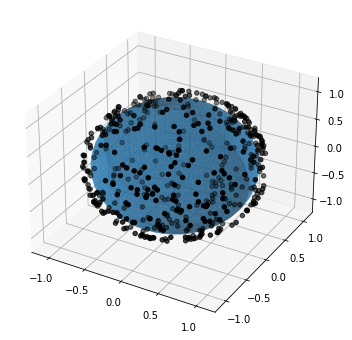

Iter  49
  MC sample 20 , loss = 364.75467457223976
  Time orientations sampling = 10.422989130020142
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 365.0897148843838
  Time vol optimisation = 60.2077054977417
Iter  50
  MC sample 20 , loss = 364.3994292614817
  Time orientations sampling = 10.567819595336914
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 364.94340187551404
  Time vol optimisation = 55.45073914527893
Iter  51
  MC sample 20 , loss = 364.2629535647362
  Time orientations sampling = 10.538909673690796
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 364.83808723552886
  Time vol optimisation = 51.58210802078247
Iter  52
  MC sample 20 , loss = 364.15745753393736
  Time orientations sampling = 10.480908393859863
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 364.74738696183823
  Time vol optimisation = 52.072181701660156
Iter  53
  MC sample 20 , loss = 364.05774195571985
  Time orientations sampling = 11.476908683776855
  Iter 20 , a =  1.0


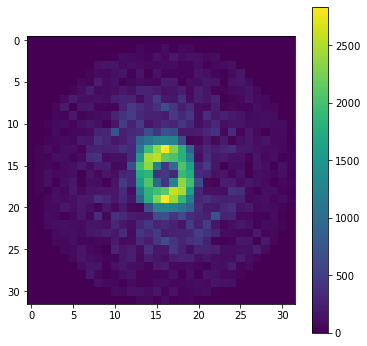

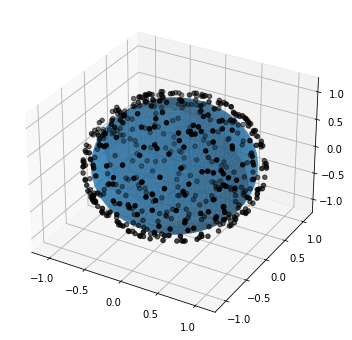

In [24]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations doesn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 1000000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6


# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
#eps_gd = 1e-4
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 21 #100
N_samples_vol = 21    

# HMC params
dt = 5
L = 4

vol0 = None
angles0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, angles_samples = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, vol0, angles0, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt, L, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)

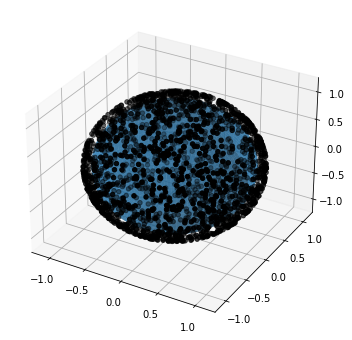

In [25]:
plot_angles(angles_rec[:2000])

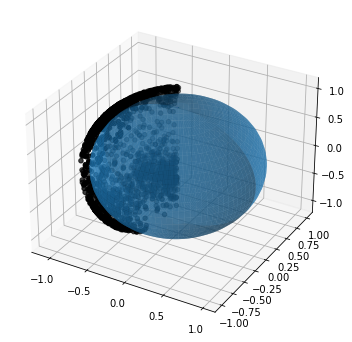

In [42]:
plot_angles(angles[:2000])

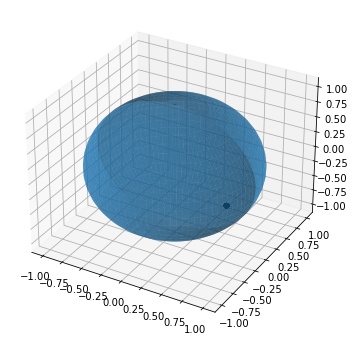

In [40]:
ae = angles_samples[:,993,:]
ae.shape
plot_angles(ae)

In [149]:
angles_samples[:,34,:]

DeviceArray([[3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.47737809, 4.43028545],
             [3.31867346, 0.477

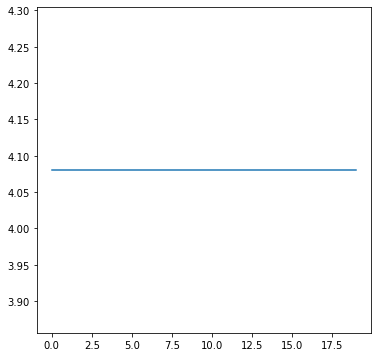

In [146]:
plt.plot(ae[:,3])

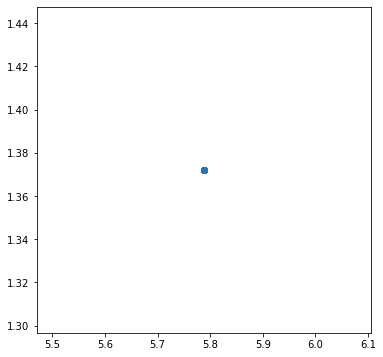

In [143]:
plt.scatter(ae[:,0], ae[:,1])

In [46]:
angles0.shape

(130000, 3)

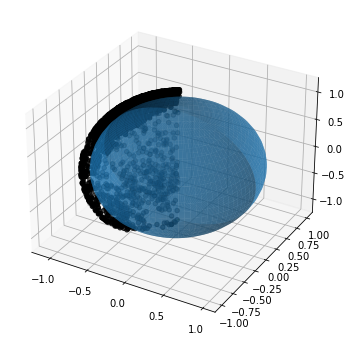

In [53]:
plot_angles(angles0[idxrand])

### MCMC vol

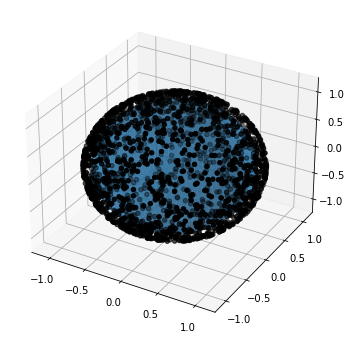

In [296]:
plot_angles(angles_rec[:2000])

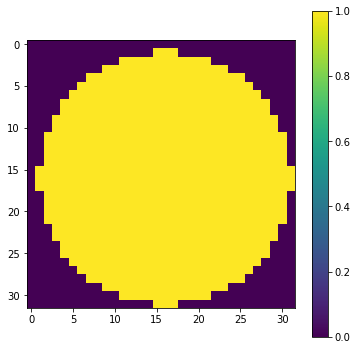

In [498]:
alpha = 1e-9
#alpha = 1e-6

radius = 0.045 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))

In [517]:
N_mc_samples = 201
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
#v0 = jnp.zeros([nx,nx,nx])*1j
v0 = v_rec
proposal_params_mala = {"tau" : 0.005}
proposal_params_hmc = {"dt" : 0.1, "L" : 4, "M" : M, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 497.437021611834
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 497.43323773191725
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 497.42969203736646
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 497.42636435811096
  Iter 100 , a =  1.0
  MC sample 100 , loss (of mean) = 497.42324453158136
  Iter 120 , a =  1.0
  MC sample 120 , loss (of mean) = 497.4203239731074
  Iter 140 , a =  1.0
  MC sample 140 , loss (of mean) = 497.41758187762724
  Iter 160 , a =  1.0
  MC sample 160 , loss (of mean) = 497.4150040675603
  Iter 180 , a =  1.0
  MC sample 180 , loss (of mean) = 497.4125587435024
  Iter 200 , a =  1.0
  MC sample 200 , loss (of mean) = 497.4102487682992


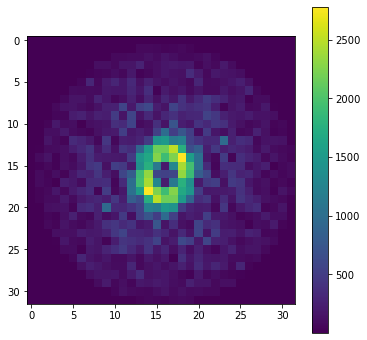

In [518]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

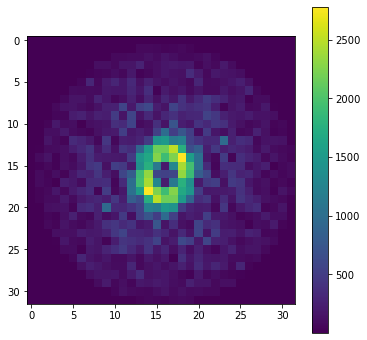

In [519]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

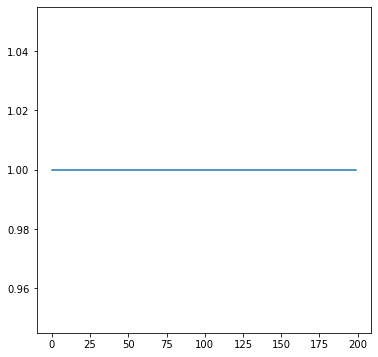

In [520]:
plt.plot(r_hmc)

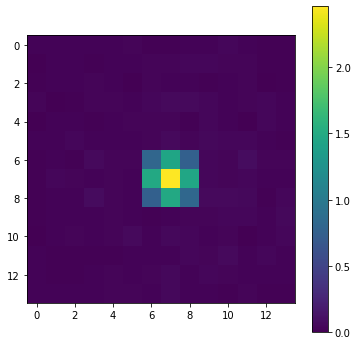

In [26]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(v_hmc_r)
plt.colorbar()

In [522]:
with mrcfile.new('../data/reconstruction_data_v_hmc4.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

### MCMC orientations

In [ ]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched0(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

### CG - choosing $\alpha$

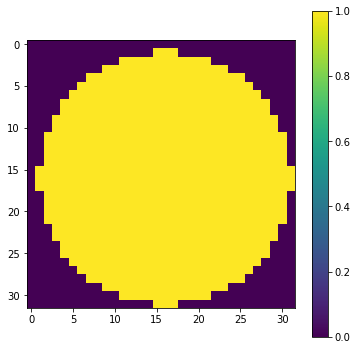

In [114]:
centre = (0,0,0)
radius = 0.045
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [115]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

sigma noise min = 340.92340087890625
sigma noise max = 940.3448486328125
sigma noise mean = 565.7948344349861


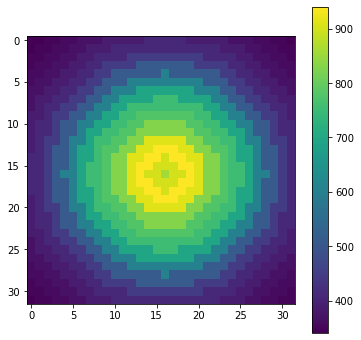

In [116]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [117]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [366]:
N_iter = 50100
eps = 3e-5
#eps = 1e-5
#eps = 1e-3
eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-6]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles_rec

In [367]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-06
  cg iter 0 ||r|| = 4.37694032162751e-05
  cg iter 50 ||r|| = 2.1489506779309842e-05
  cg iter 100 ||r|| = 1.789987965142398e-05
  cg iter 150 ||r|| = 1.714359572091724e-05
  cg iter 200 ||r|| = 1.404590084298667e-05
  cg iter 250 ||r|| = 8.745262619775166e-06
  cg iter 300 ||r|| = 5.012923886532041e-06
  cg iter 350 ||r|| = 7.450386716148475e-06
  cg iter 400 ||r|| = 7.439992935234844e-06
  cg iter 450 ||r|| = 3.81366981218086e-06
  cg iter 500 ||r|| = 4.3644599943709715e-06
  cg iter 550 ||r|| = 5.292100161953243e-06
  cg iter 600 ||r|| = 1.3217424722086446e-06
  cg iter 650 ||r|| = 4.53934739677973e-06
  cg iter 700 ||r|| = 2.0203129512738703e-06
  cg iter 750 ||r|| = 3.887846231788831e-06
  cg iter 786 ||r|| = 9.859437181520932e-07
  fid = 0.7179254193897301
  reg = 43.84785952906974
  loss = 0.35966427544733015
  Time = 60.1835081577301


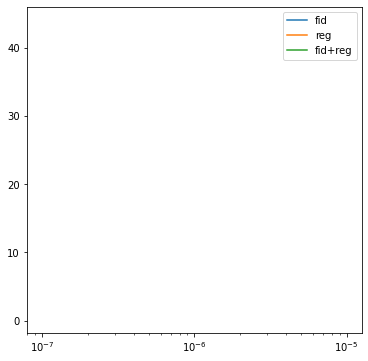

In [368]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

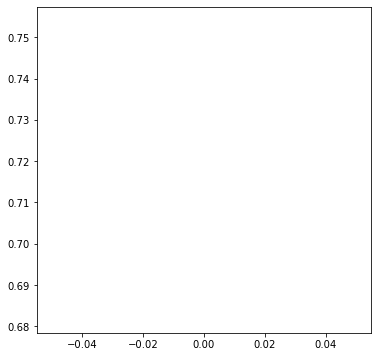

In [369]:
plt.plot(fids)

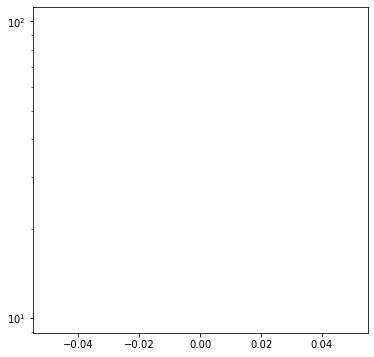

In [370]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [371]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [372]:
alphas[alpha_idx]

DeviceArray(1.e-06, dtype=float64)

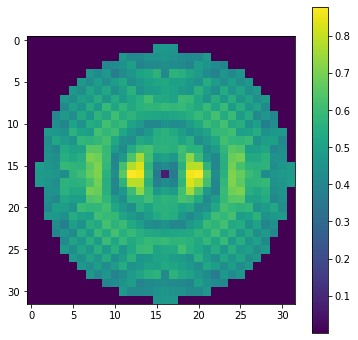

In [373]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

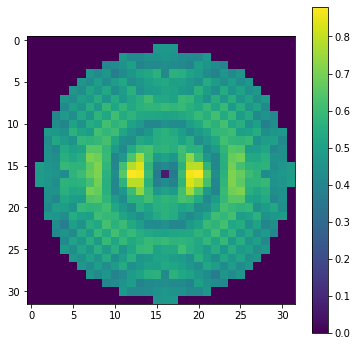

In [374]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [375]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [376]:
#alpha_idx = 2

1e-06


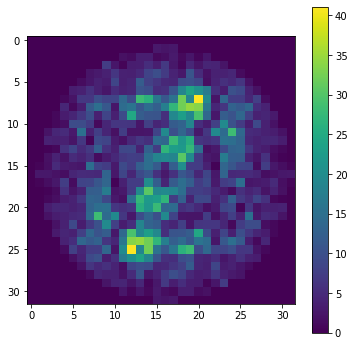

In [377]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

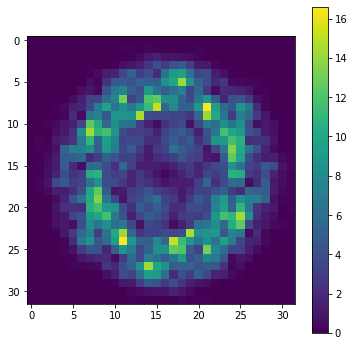

In [378]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

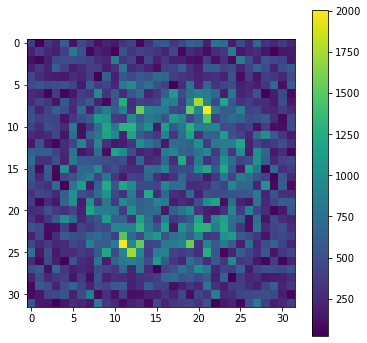

In [379]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

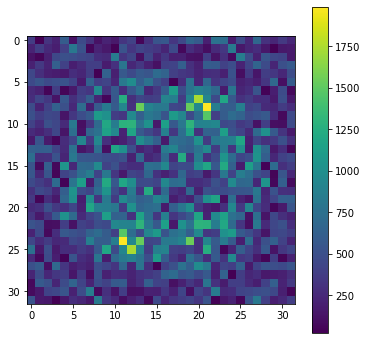

In [380]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

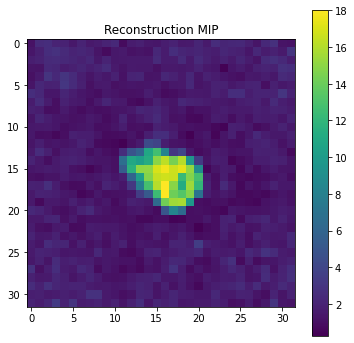

In [381]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

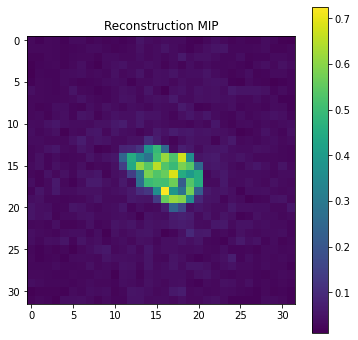

In [382]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [384]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [94]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(10, 32)

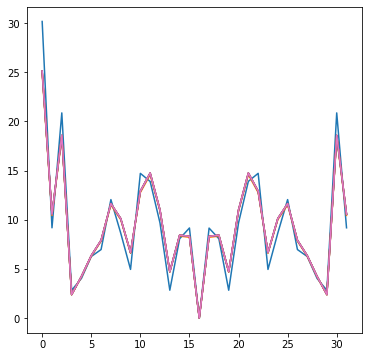

In [124]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [137]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [138]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [127]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


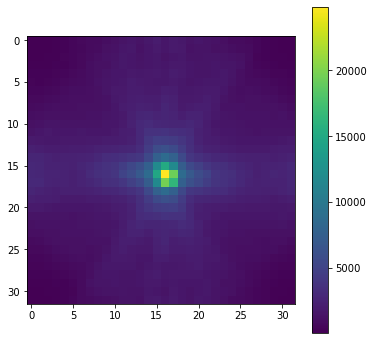

In [128]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [129]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

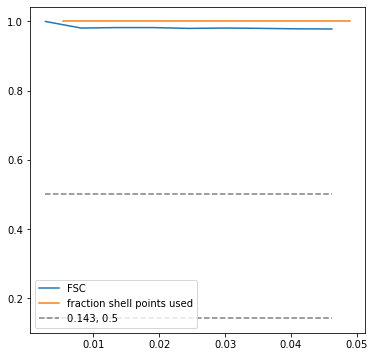

In [139]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

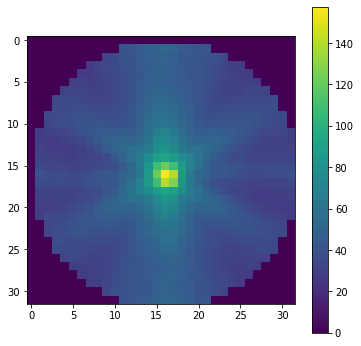

In [140]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

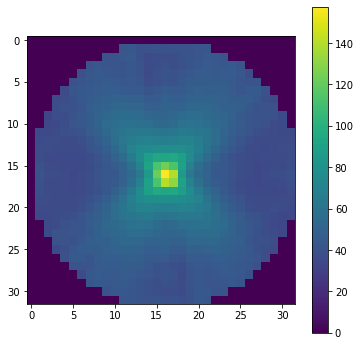

In [141]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

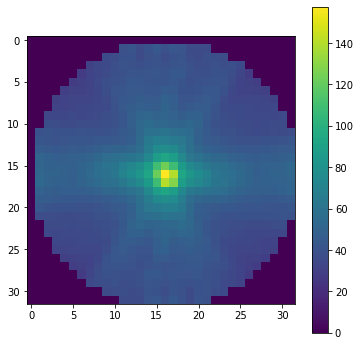

In [142]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [149]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [152]:
jnp.min(jnp.abs(omega))

DeviceArray(0.001, dtype=float64)

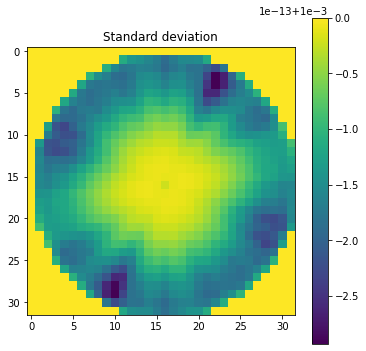

In [171]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

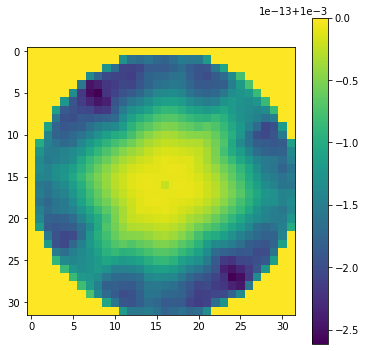

In [172]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

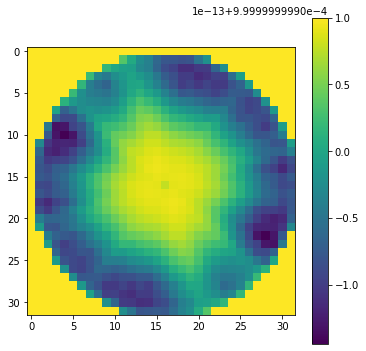

In [173]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

1e-06
1.000001
1e-06


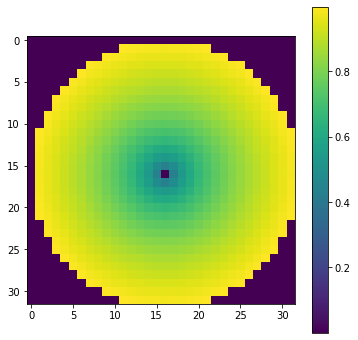

In [174]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


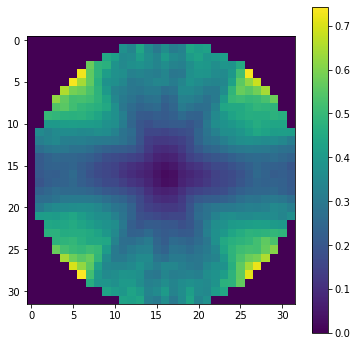

In [175]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [176]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [196]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
alphas = [1e-10, 1e-9, 1e-8, 1e-7]

angles_gd = angles_rec

In [197]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-10
  sgd epoch 0: mean gradient = 1.4729407511529204e-07
  sgd epoch 50: mean gradient = 6.929328984682533e-09
  fid = 0.7156186797013532
  reg = 81203.15309067581
  loss = 0.35793926489562167
  Time = 21.56503438949585
alpha = 1e-09
  sgd epoch 0: mean gradient = 1.478003812584484e-07
  sgd epoch 50: mean gradient = 7.60058385263992e-09
  fid = 0.7158457744341501
  reg = 69454.35128632141
  loss = 0.3590341568376562
  Time = 21.490625143051147
alpha = 1e-08
  sgd epoch 0: mean gradient = 1.41740796721962e-07
  sgd epoch 50: mean gradient = 1.1299338934994461e-08
  sgd epoch 100: mean gradient = 2.5887754490609068e-08
  sgd epoch 150: mean gradient = 1.2294315039249511e-09
  fid = 0.7211072722198489
  reg = 30100.955157007047
  loss = 0.36536978893504557
  Time = 40.72334885597229
alpha = 1e-07
  sgd epoch 0: mean gradient = 6.3791124078498e-08
  sgd epoch 50: mean gradient = 2.4142365269046486e-08
  sgd epoch 100: mean gradient = 3.794820156606282e-08
  sgd epoch 150: mean 

In [203]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

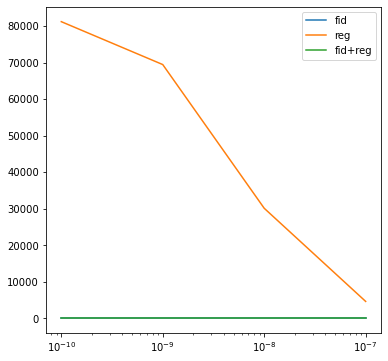

In [204]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

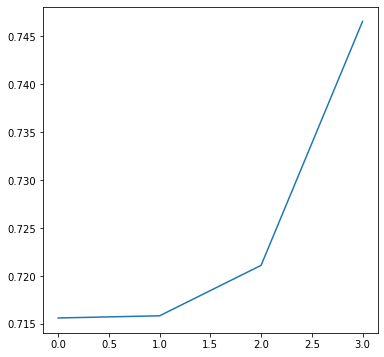

In [205]:
plt.plot(fids)

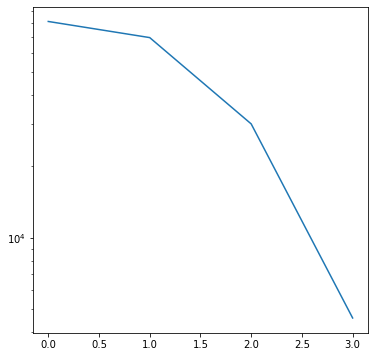

In [206]:
plt.semilogy(regs)

In [207]:
alphas[2]

DeviceArray(1.e-08, dtype=float64)

In [208]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

0.6971769473547622


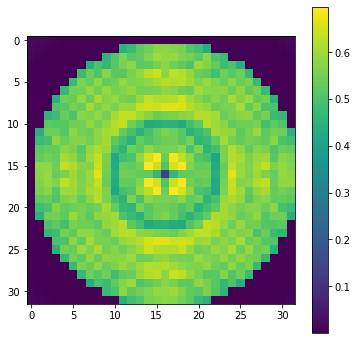

In [209]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.6971769473547622


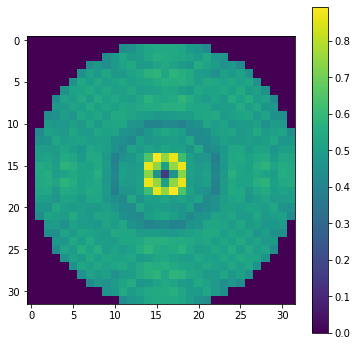

In [210]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

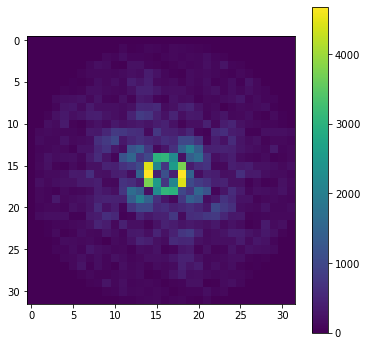

In [213]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

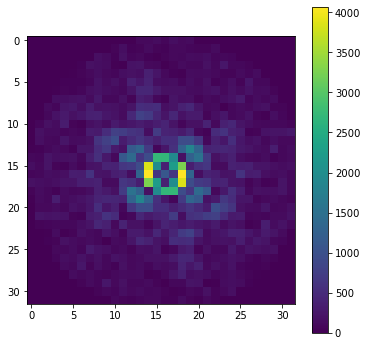

In [214]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

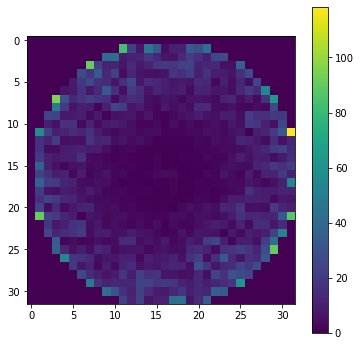

In [217]:
err = vgds[1] - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

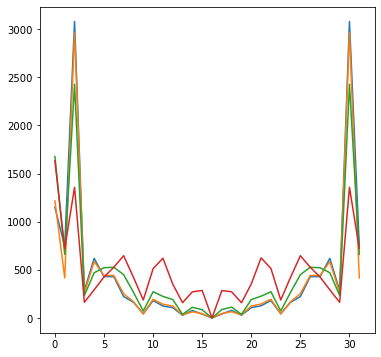

In [227]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


Text(0.5, 1.0, 'Reconstruction MIP')

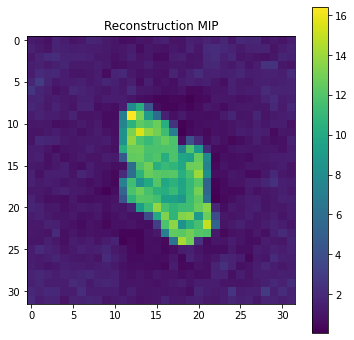

In [228]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

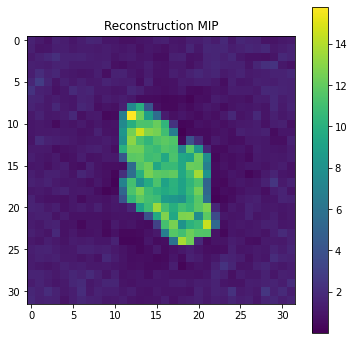

In [229]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [240]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [231]:
idx = 100

In [236]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

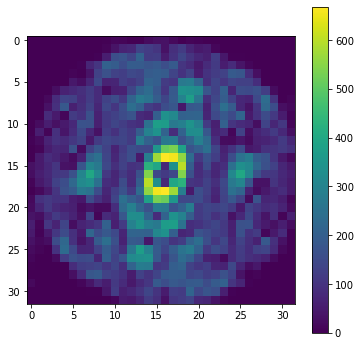

In [237]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

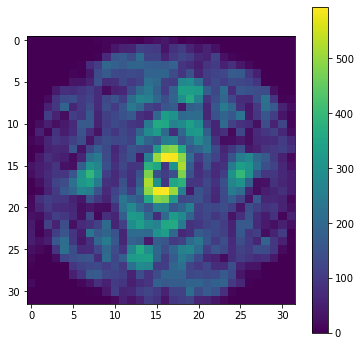

In [238]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

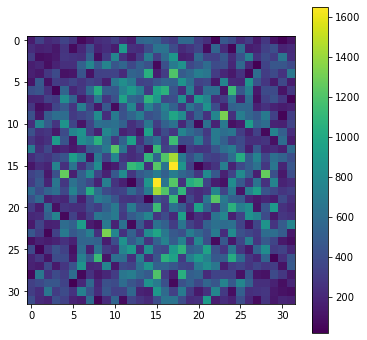

In [239]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()